# Comparing centered and non-centered parameterizations

This notebookbook experiments with a centered (standard) and [non-centered](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) parameterizations of the SpecletThree model.
This involves fitting 3 models (so takes around 20 minutes to run completely), the first with a normal parameterization, the second with the non-centered parameterization, and the third with the non-centered parameterization and the optional *KRAS* covariate.
It is immediately apparent that the non-centered version works much better by having 0 divergences during fitting and producing far superior trace plots. 
This is true when the *KRAS* covariate is included, too.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.io import cache_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.models.speclet_three import SpecletThree

In [4]:
notebook_tic = time()
warnings.simplefilter(action="ignore", category=UserWarning)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

## Centered parameterization

First, a SpecletThree model is fit without any reparameterization.
The core of the model is

$$
\mu = h_k + g_{k, j} + b_i
$$

for gene $k$ in cell line $j$ run in batch $i$.

We can see that there is difficulty sampling from the posterior resulting in divergences and wandering traces.

In [5]:
sp3 = SpecletThree(
    "subsample-centered-reparamterization",
    root_cache_dir=cache_io.default_cache_dir(),
    debug=True,
    kras_cov=False,
    kras_mutation_minimum=2,
    noncentered_param=False,
)

In [6]:
sp3.build_model()
sp3_mcmc_res = sp3.mcmc_sample_model(mcmc_draws=1000, tune=1000, chains=3, cores=3)

[05/26/21 07:48:29] INFO     Calling `model_specification()` method.     ]8;id=1622029709.231951-562489;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:166

                    INFO     Beginning PyMC3 model specification.        ]8;id=1622029709.237296-517393;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:248

                    WARNING  Dropping data points of sgRNA that    ]8;id=1622029709.313905-814999;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:125
                             map to multiple genes.

                    WARNING  Dropping data points with missing     ]8;id=1622029709.3326468-744172;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:131
                             copy number.

                    INFO     Getting Theano shared variables.            ]8;id=1622029709.400044-473325;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:255

                    INFO     Creating PyMC3 model (centered              ]8;id=1622029709.41378-503896;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:276
                             parameterization).

[05/26/21 07:48:38] INFO     Beginning MCMC sampling.                    ]8;id=1622029718.028233-191653;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:271

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, σ_σ, b, σ_b, μ_b, g, σ_g, μ_g, h, σ_h, μ_h]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 380 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[05/26/21 07:55:55] INFO     Finished MCMC sampling - caching results.   ]8;id=1622030155.632521-525253;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:284

                    INFO     Caching InferenceData to '/Users/admin/Lab ]8;id=1622030155.639025-215832;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:245
                             _Projects/speclet/models/speclet-three_sub                      
                             sample-centered-reparamterization/mcmc/inf                      
                             erence-data.nc'.

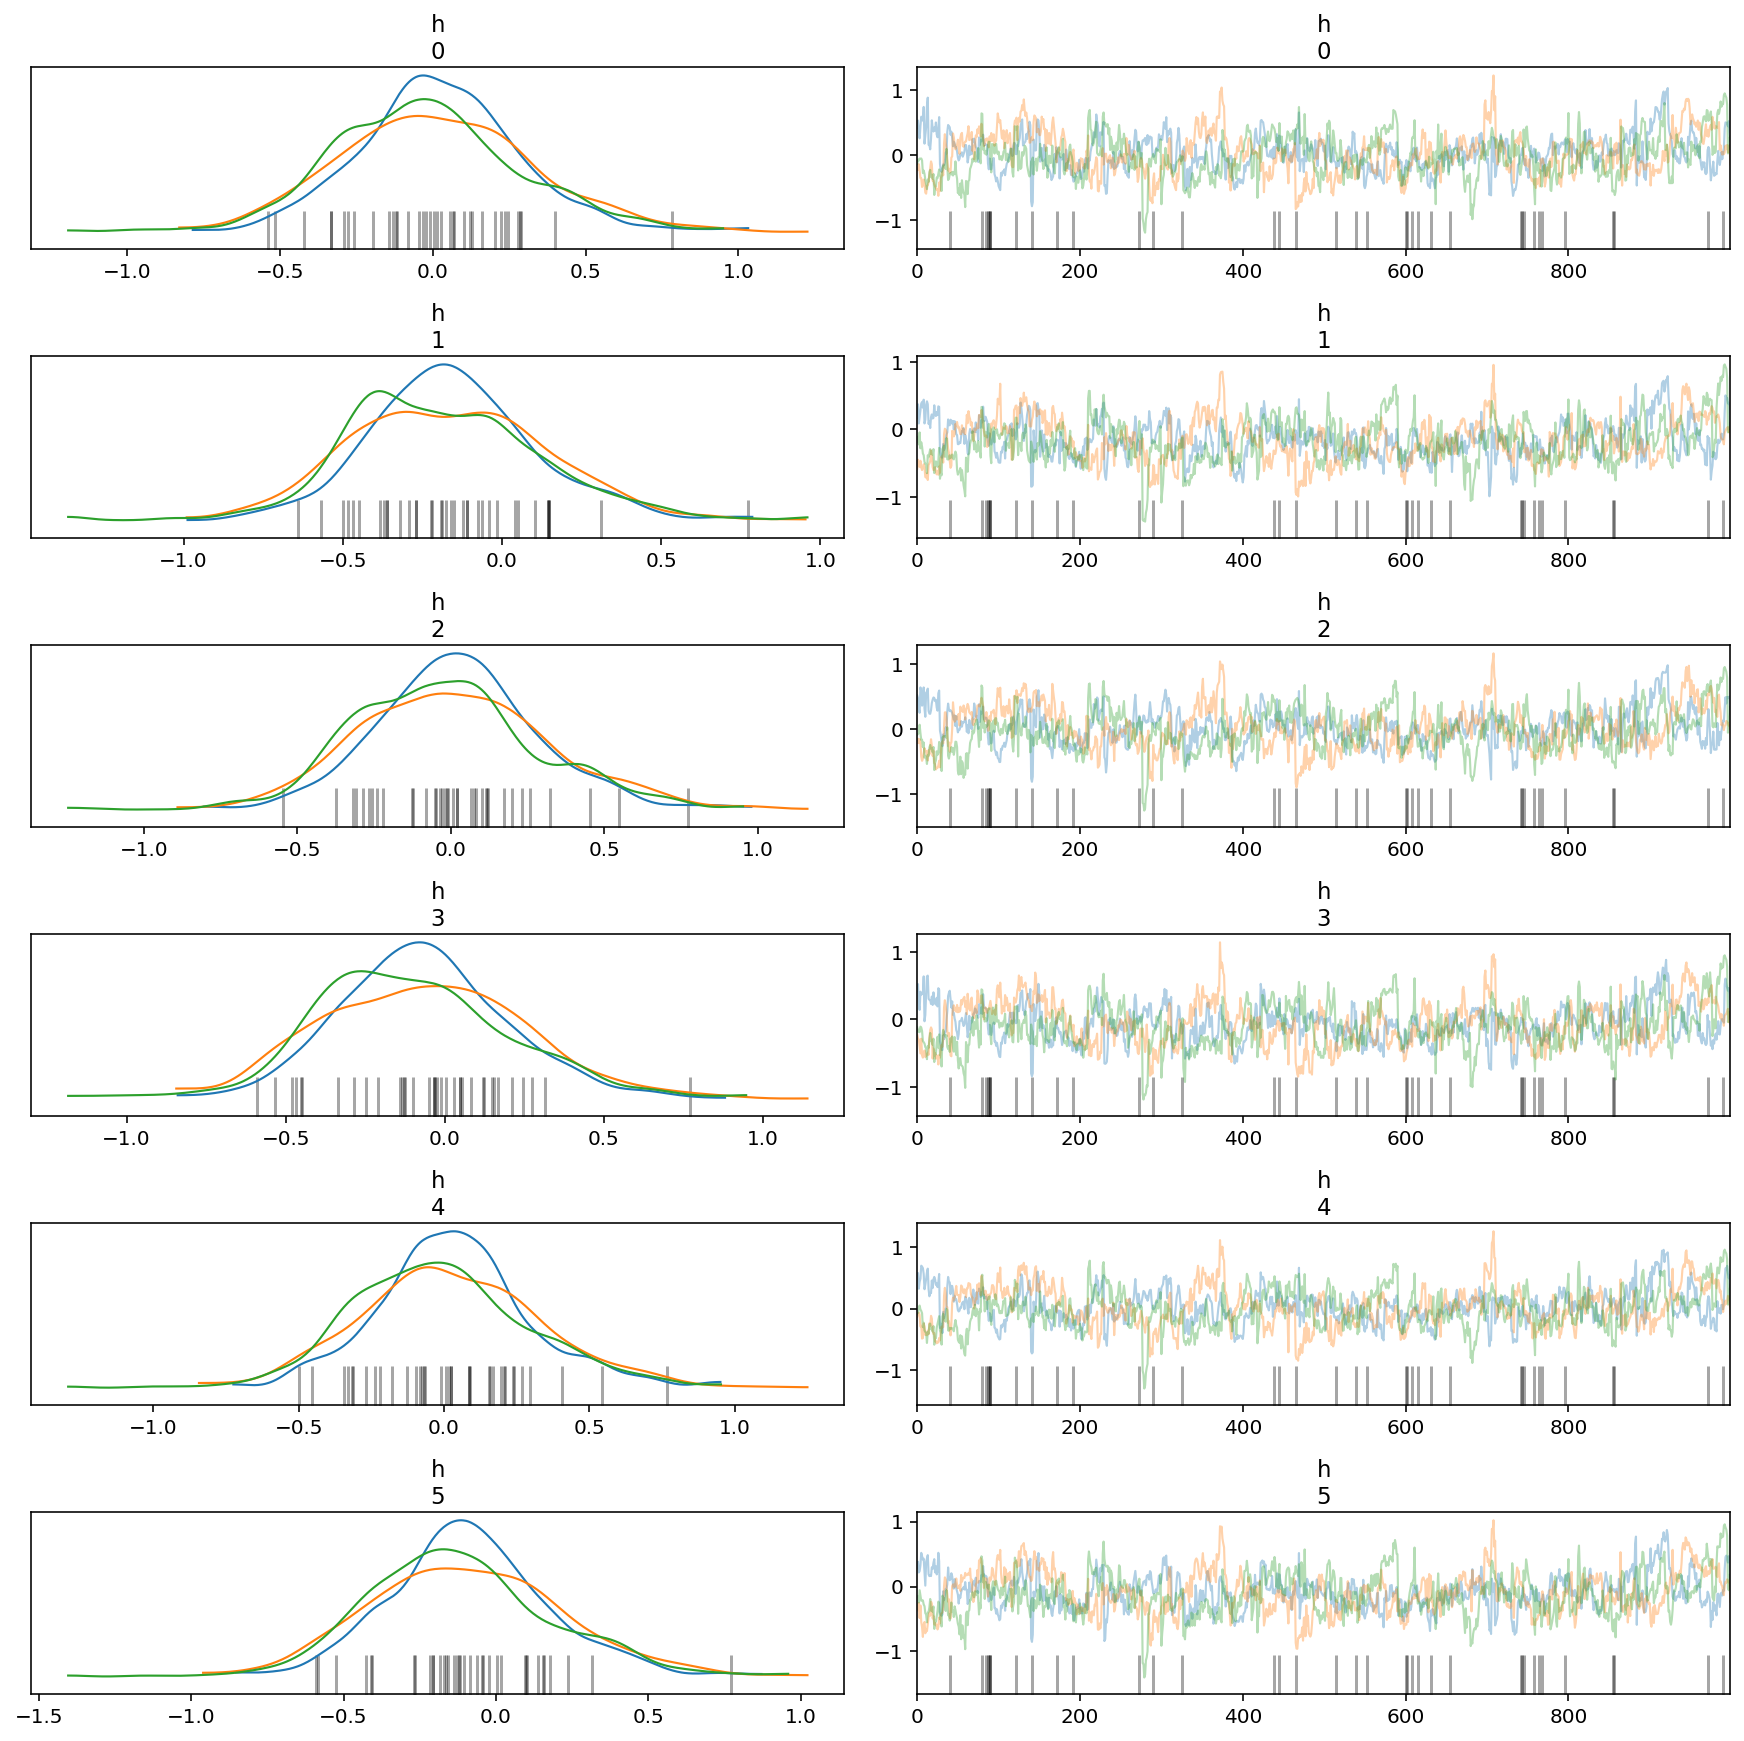

In [7]:
az.plot_trace(sp3_mcmc_res, var_names=["h"], compact=False);

## Non-centered reparamaterization

Now the same model is fit but reparameterization using the non-centered method.
There are no divergences during sampling and the resulting trace plots look perfect.

In [8]:
sp3_noncentered = SpecletThree(
    "subsample-noncentered-reparamterization",
    root_cache_dir=cache_io.default_cache_dir(),
    debug=True,
    kras_cov=False,
    kras_mutation_minimum=2,
    noncentered_param=True,
)

In [9]:
sp3_noncentered.build_model()
sp3_mcmc_res_noncentered = sp3_noncentered.mcmc_sample_model(
    mcmc_draws=1000, tune=1000, chains=3, cores=3
)

[05/26/21 07:55:59] INFO     Calling `model_specification()` method.     ]8;id=1622030159.488626-391455;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:166

                    INFO     Beginning PyMC3 model specification.        ]8;id=1622030159.491837-799560;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:248

                    INFO     Getting Theano shared variables.            ]8;id=1622030159.541336-776698;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:255

                    INFO     Creating PyMC3 model (non-centered          ]8;id=1622030159.545992-980327;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:264
                             parameterization).

[05/26/21 07:56:01] INFO     Beginning MCMC sampling.                    ]8;id=1622030161.119506-985588;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:271

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, σ_σ, b_offset, σ_b, μ_b, g_offset, σ_g, μ_g, h_offset, σ_h, μ_h]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 384 seconds.
The number of effective samples is smaller than 25% for some parameters.


[05/26/21 08:03:18] INFO     Finished MCMC sampling - caching results.   ]8;id=1622030598.749312-40713;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:284

                    INFO     Caching InferenceData to '/Users/admin/Lab ]8;id=1622030598.76282-340457;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:245
                             _Projects/speclet/models/speclet-three_sub                      
                             sample-noncentered-reparamterization/mcmc/                      
                             inference-data.nc'.

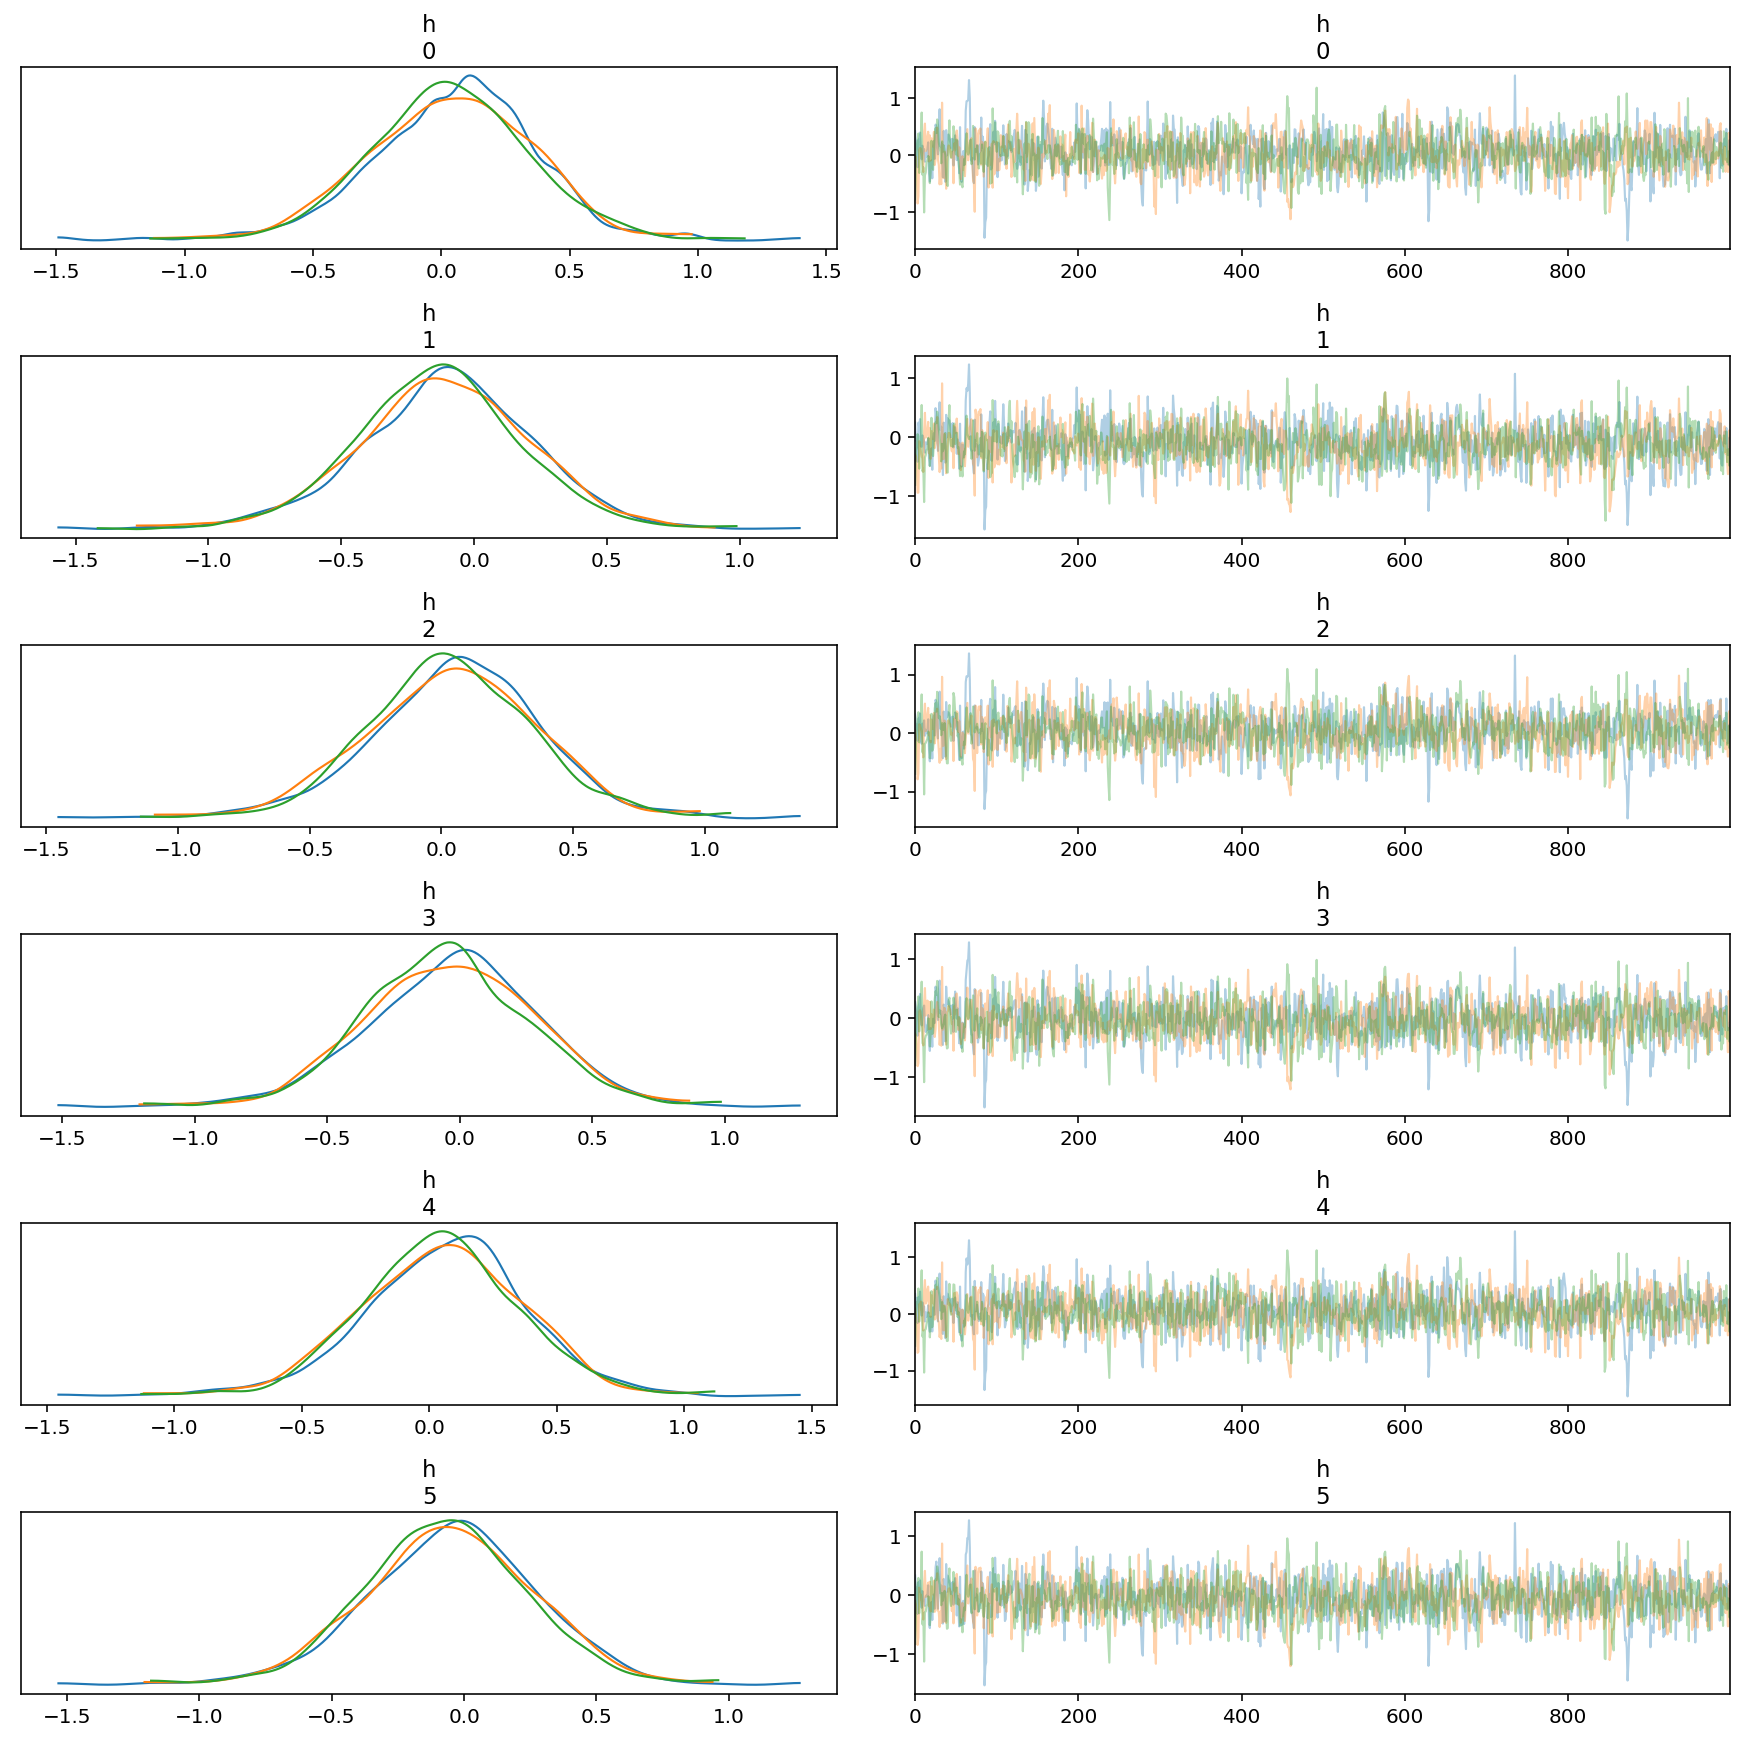

In [10]:
az.plot_trace(sp3_mcmc_res_noncentered, var_names=["h"], compact=False);

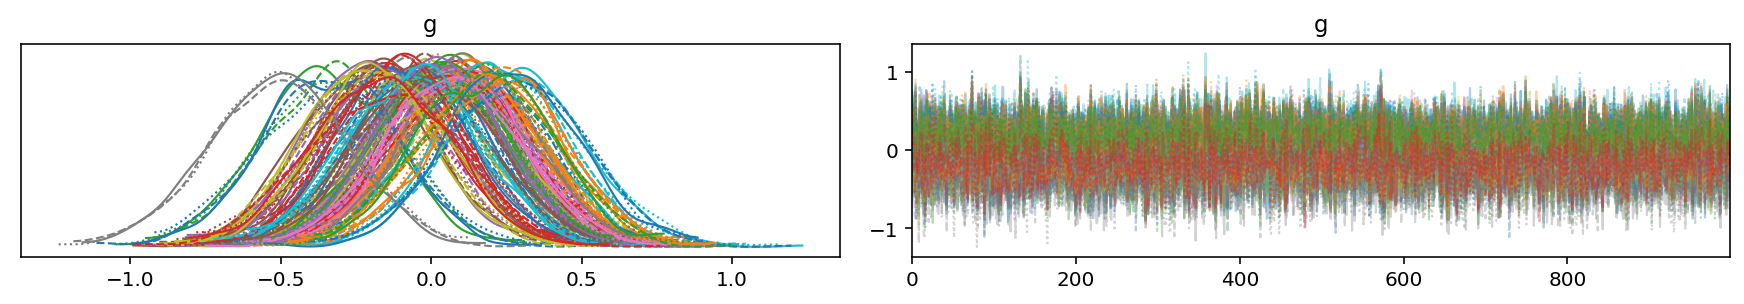

In [11]:
az.plot_trace(sp3_mcmc_res_noncentered, var_names=["g"], compact=True);

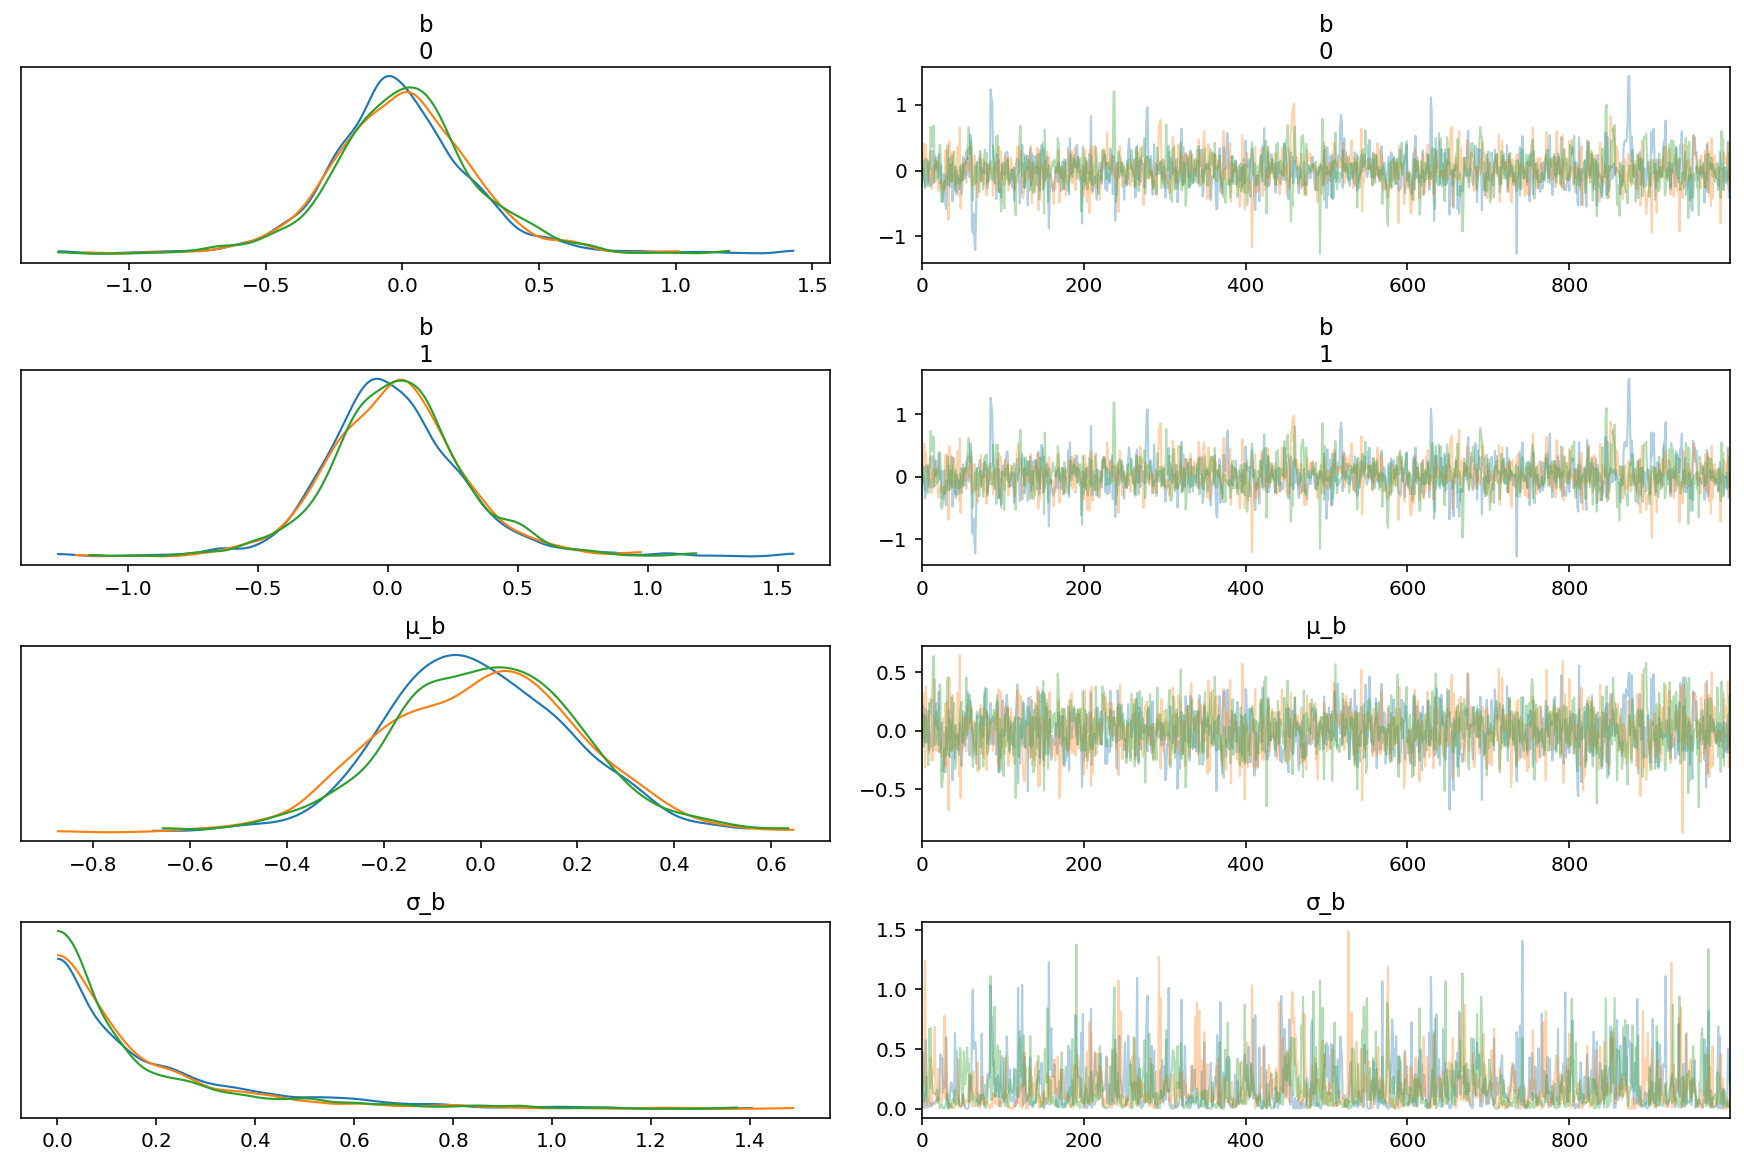

In [12]:
az.plot_trace(sp3_mcmc_res_noncentered, var_names=["b", "μ_b", "σ_b"], compact=False);

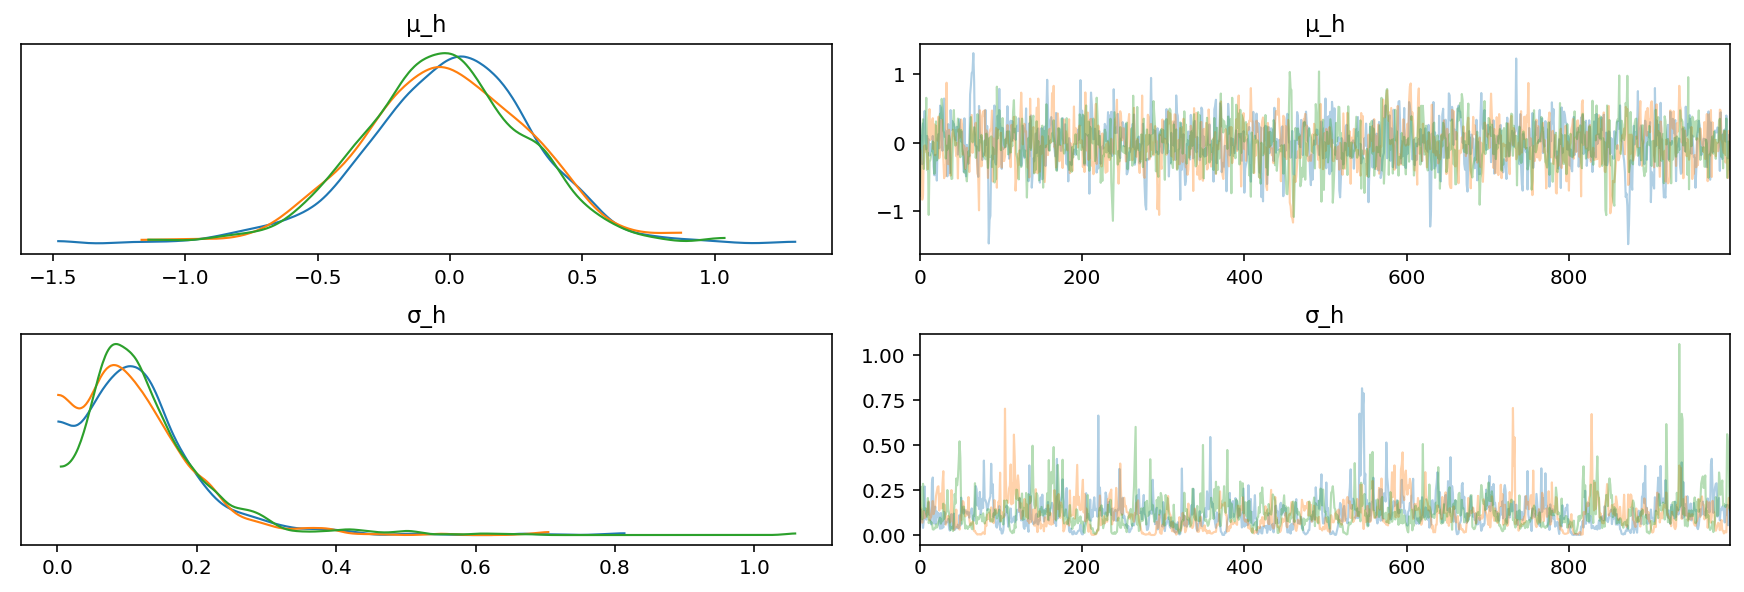

In [13]:
az.plot_trace(sp3_mcmc_res_noncentered, var_names=["μ_h", "σ_h"], compact=False);

## Non-centered reparamaterization with the *KRAS* covariate

Finally, the *KRAS* covariate is included and the model still samples great.
The model now has the following core structure

$$
\mu = h_k + g_{k, j} + a_{k, p} + b_i
$$

for *KRAS* allele $p$.

In [14]:
sp3_noncentered_kras = SpecletThree(
    "subsample-noncentered-reparamterization-kras",
    root_cache_dir=cache_io.default_cache_dir(),
    debug=True,
    kras_cov=True,
    kras_mutation_minimum=2,
    noncentered_param=True,
)

In [15]:
sp3_noncentered_kras.build_model()
sp3_mcmc_res_noncentered_kras = sp3_noncentered_kras.mcmc_sample_model(
    mcmc_draws=1000, tune=1000, chains=3, cores=3
)

[05/26/21 08:03:28] INFO     Calling `model_specification()` method.     ]8;id=1622030608.4021142-413857;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:166

                    INFO     Beginning PyMC3 model specification.        ]8;id=1622030608.404605-746822;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:248

                    INFO     Getting Theano shared variables.            ]8;id=1622030608.441639-232005;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:255

                    INFO     Creating PyMC3 model (non-centered          ]8;id=1622030608.445547-805203;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_three.py\speclet_three.py]8;;\:264
                             parameterization).

[05/26/21 08:03:30] INFO     Beginning MCMC sampling.                    ]8;id=1622030610.4288158-62372;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:271

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, σ_σ, a_offset, σ_a, μ_a, b_offset, σ_b, μ_b, g_offset, σ_g, μ_g, h_offset, σ_h, μ_h]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 641 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


[05/26/21 08:15:18] INFO     Finished MCMC sampling - caching results.   ]8;id=1622031318.052567-726980;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:284

                    INFO     Caching InferenceData to '/Users/admin/Lab ]8;id=1622031318.058678-685791;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:245
                             _Projects/speclet/models/speclet-three_sub                      
                             sample-noncentered-reparamterization-kras/                      
                             mcmc/inference-data.nc'.

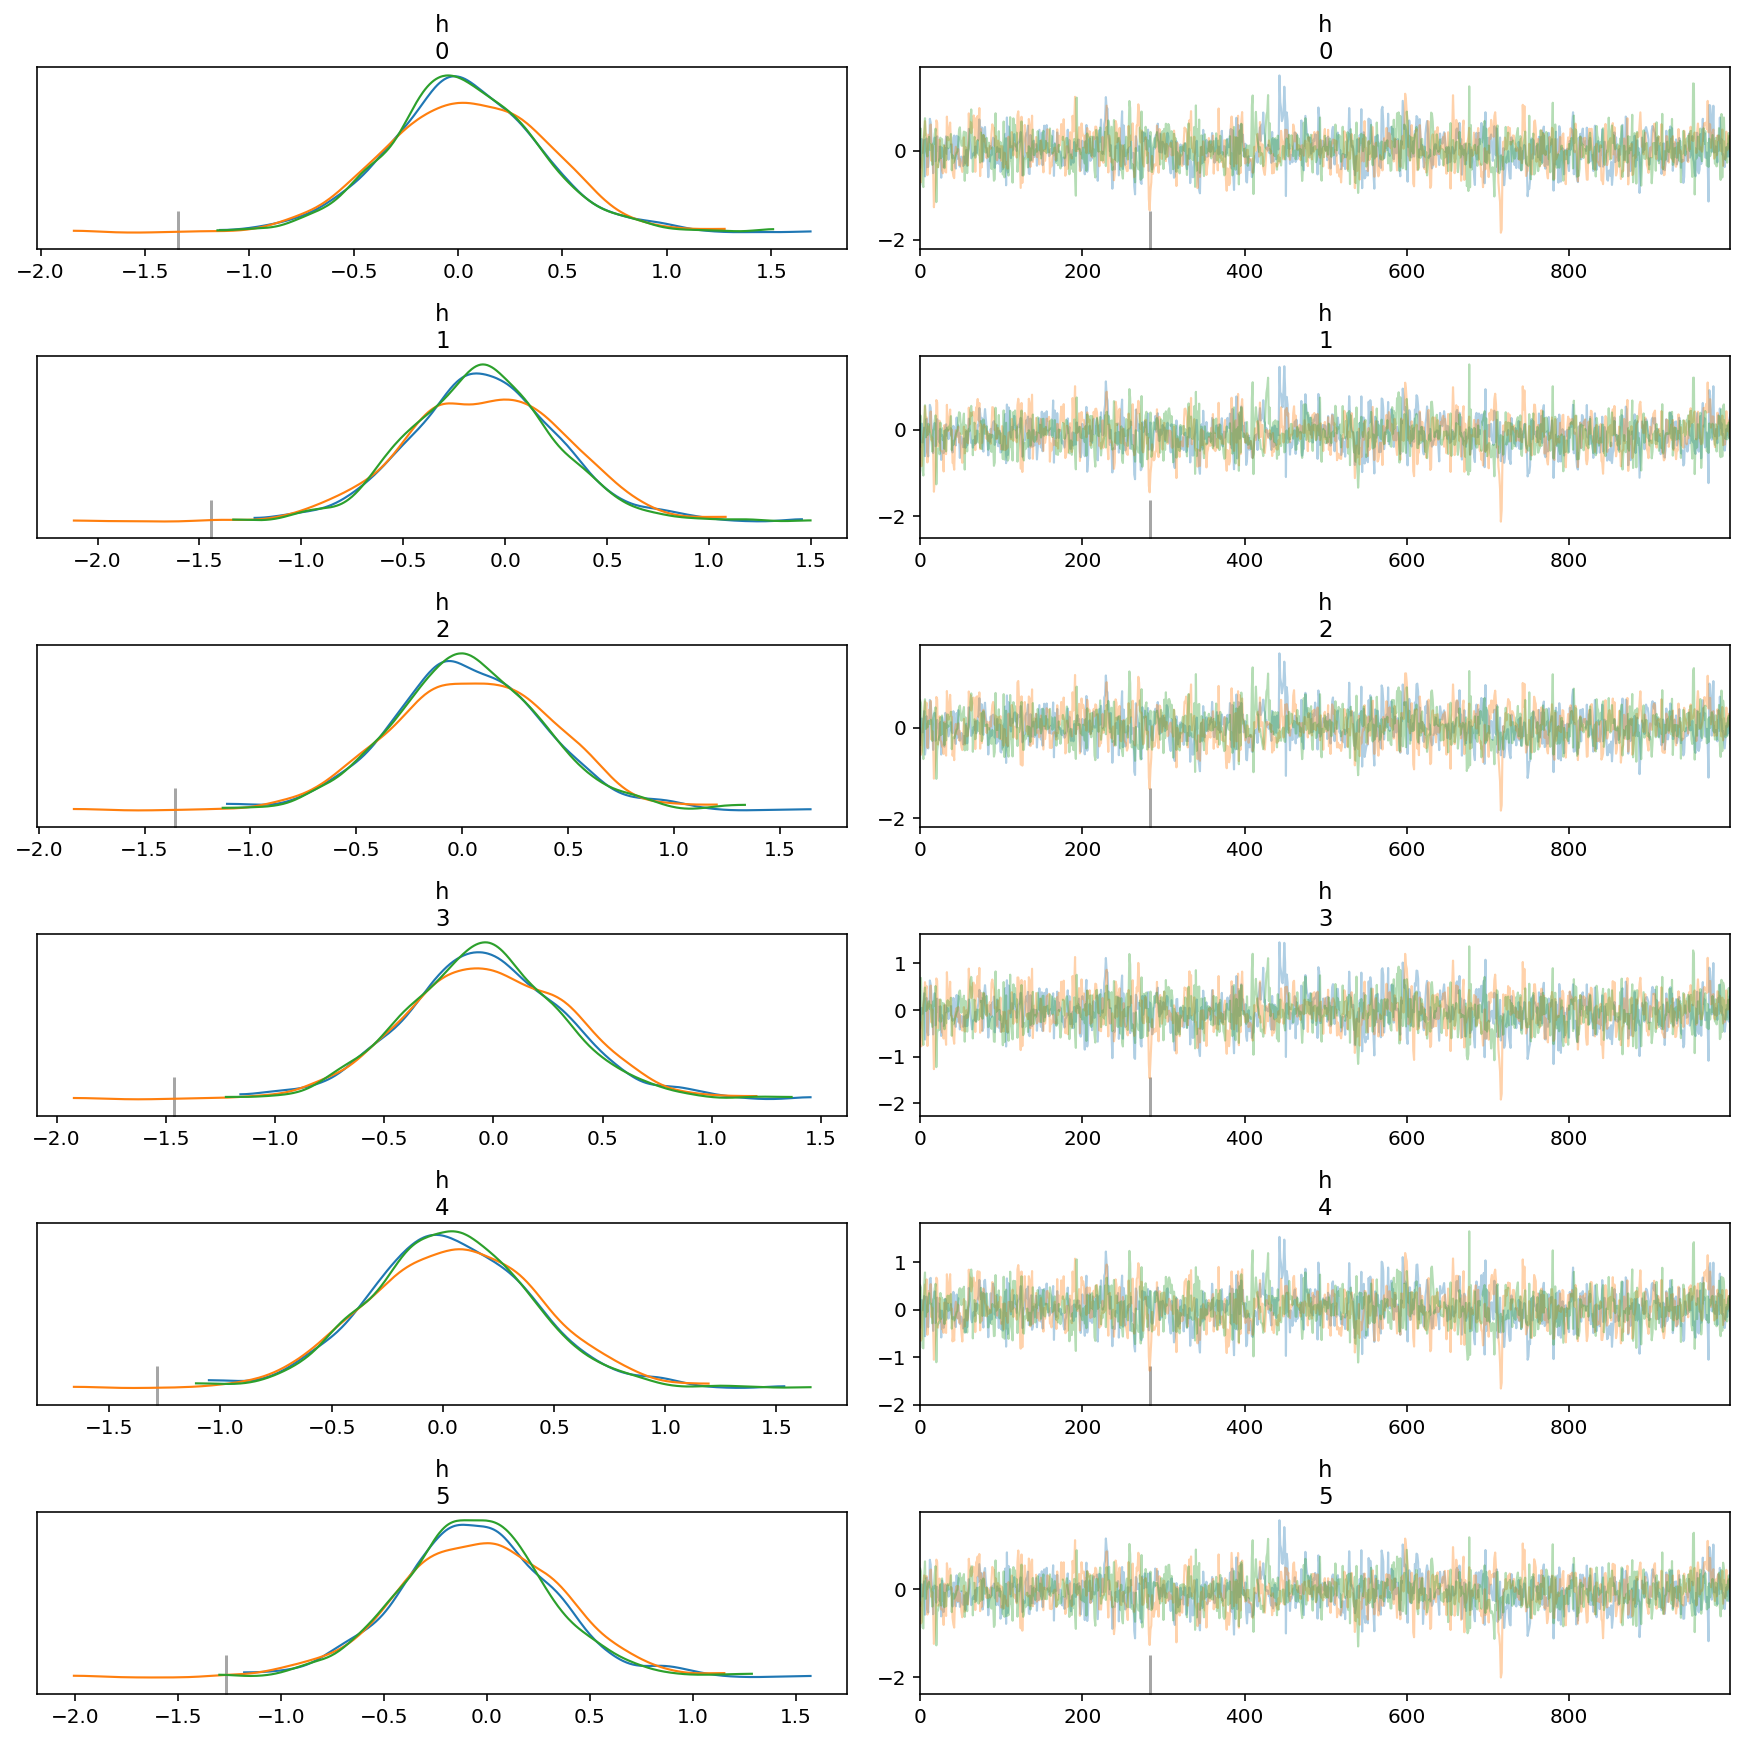

In [16]:
az.plot_trace(sp3_mcmc_res_noncentered_kras, var_names=["h"], compact=False);

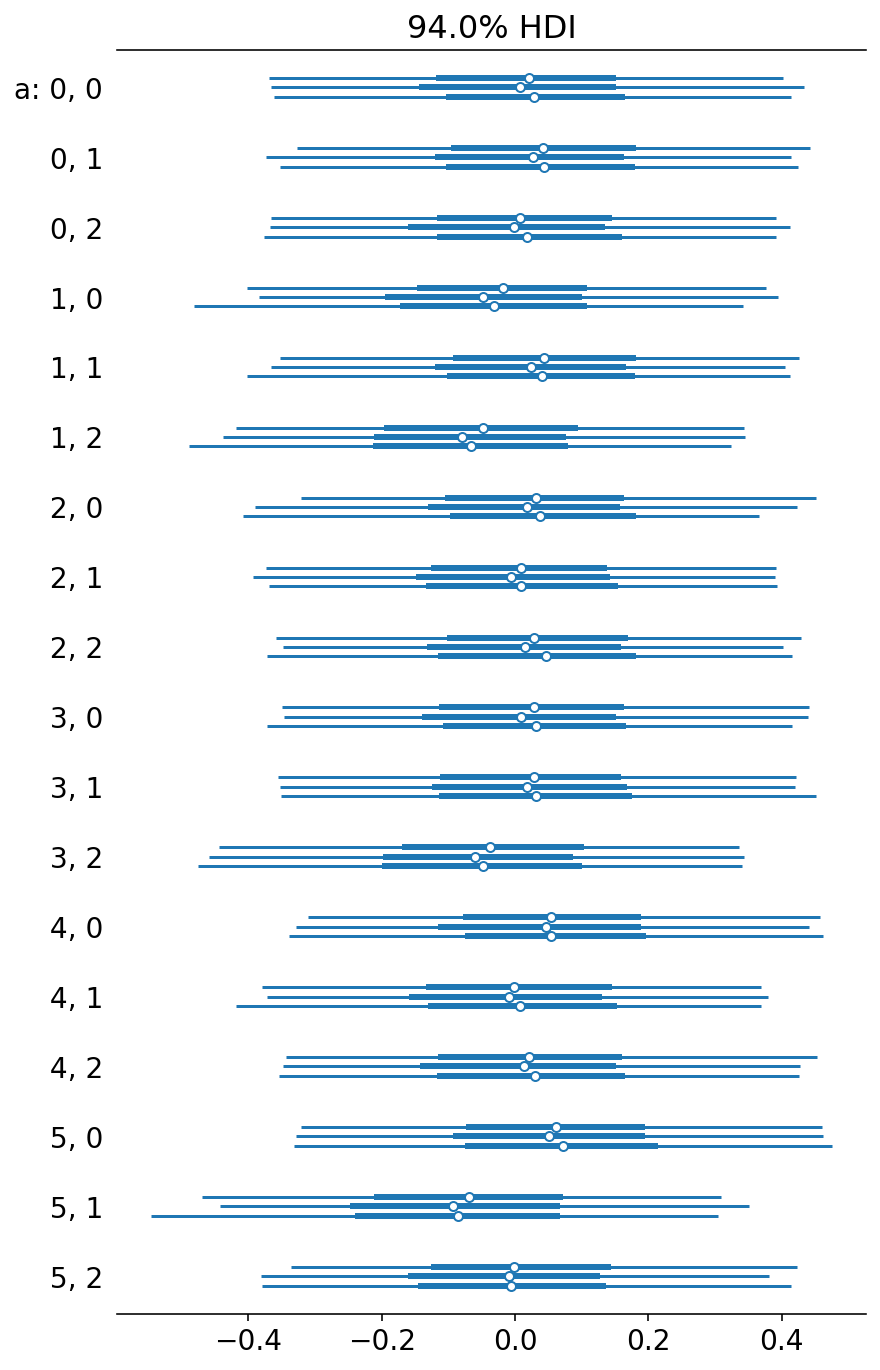

In [17]:
az.plot_forest(sp3_mcmc_res_noncentered_kras, var_names=["a"]);

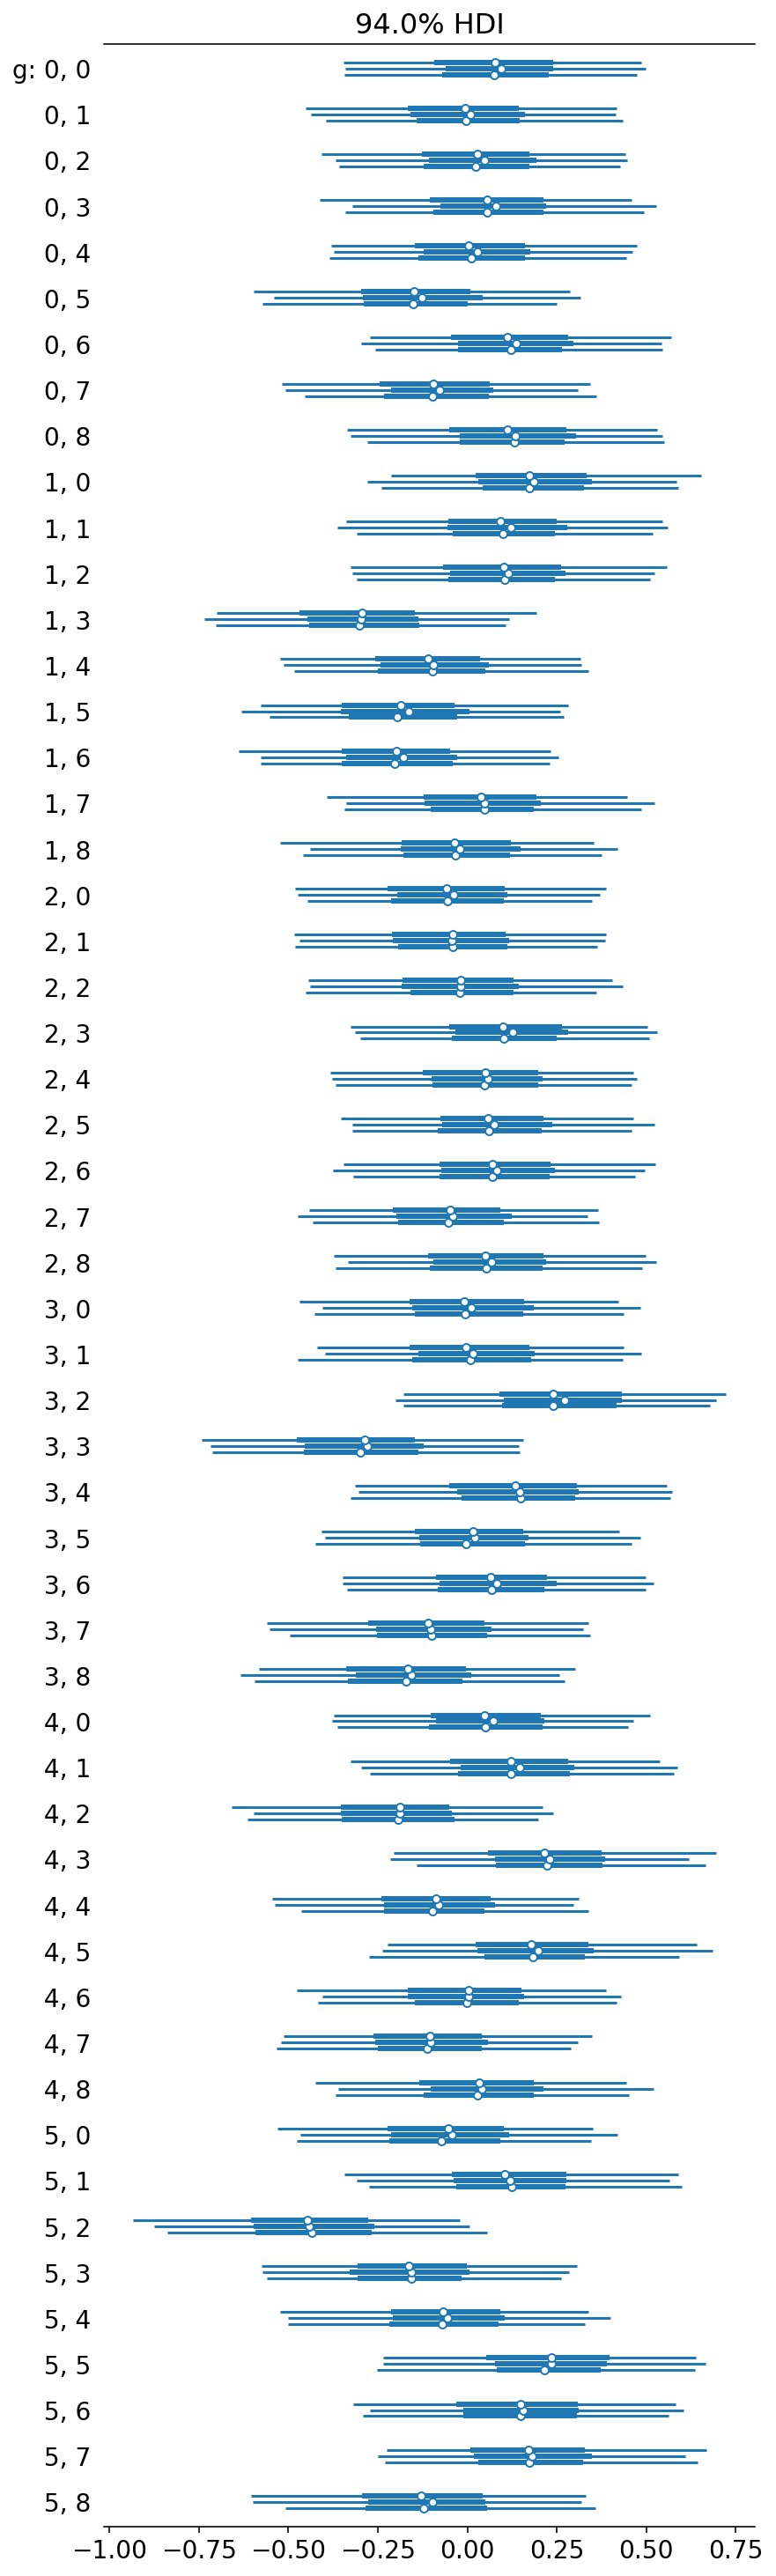

In [18]:
az.plot_forest(sp3_mcmc_res_noncentered_kras, var_names=["g"]);

---

In [19]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 26.96 minutes


In [20]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-05-26

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: noncentered-reparam

arviz     : 0.11.2
plotnine  : 0.7.1
re        : 2.2.1
matplotlib: 3.3.4
pymc3     : 3.11.1
seaborn   : 0.11.1
pandas    : 1.2.3
numpy     : 1.20.1
theano    : 1.0.5

